The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


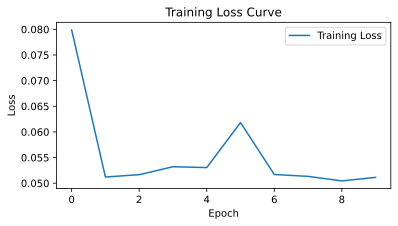

[0.04332266002893448, 0.04517311602830887, -0.009662467986345291, -0.016038978472352028, -0.03780624270439148, -0.06058638542890549, -0.08593470603227615, -0.10847005993127823, -0.13381309807300568, -0.15960773825645447, -0.18609784543514252, -0.21302145719528198, -0.24064253270626068, -0.26858416199684143, -0.2967647314071655, -0.3250070810317993, -0.3531433045864105, -0.3809574544429779, -0.4082569479942322, -0.4348410367965698, -0.46052077412605286, -0.48512279987335205, -0.5084988474845886, -0.5305284261703491, -0.5511227250099182, -0.5702260136604309, -0.5878147482872009, -0.6038951277732849, -0.618499755859375, -0.6316829323768616, -0.6435160636901855, -0.6540828943252563, -0.6634750366210938, -0.6717880368232727, -0.6791183352470398, -0.6855605244636536, -0.6912055015563965, -0.6961389780044556, -0.7004406452178955, -0.7041839957237244, -0.707435667514801, -0.7102559208869934, -0.7126986980438232, -0.7148122191429138, -0.7166388034820557, -0.7182161211967468, -0.7195772528648376

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import matplotlib.pyplot as plt

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0):
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Use only the last time step for prediction
        return out

class RNNData(torch.utils.data.Dataset):
    def __init__(self, T=1000, num_train=600, tau=4):
        self.T = T
        self.num_train = num_train
        self.tau = tau
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

    def __len__(self):
        return len(self.x) - self.tau

    def __getitem__(self, idx):
        features = [self.x[idx + i] for i in range(self.tau)]
        features = torch.stack(features)
        label = self.x[idx + self.tau]
        return features, label

class RNNTrainer:
    def __init__(self, input_size, hidden_size, output_size, lr=0.01, max_epochs=20):
        self.model = RNN(input_size, hidden_size, output_size)
        self.data = RNNData()
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.max_epochs = max_epochs

    def train(self):
        losses = []
        data_loader = torch.utils.data.DataLoader(self.data, batch_size=16, shuffle=True)
        for epoch in range(1, self.max_epochs + 1):
            epoch_loss = 0.0
            for inputs, targets in data_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs.unsqueeze(2), None)
                loss = self.criterion(outputs, targets.unsqueeze(1))
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            avg_epoch_loss = epoch_loss / len(data_loader)
            losses.append(avg_epoch_loss)

        # Plot training loss curve
        plt.plot(losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Curve')
        plt.legend()
        plt.show()

    def predict(self):
      with torch.no_grad():
          predictions = []
          input_seq = self.data.x[:self.data.tau].unsqueeze(0).unsqueeze(-1)
          hidden = None
          for i in range(len(self.data.x) - self.data.tau):
              output = self.model(input_seq, hidden)
              predictions.append(output.item())
              input_seq = torch.cat((input_seq[:, 1:, :], output.unsqueeze(2)), dim=1)  # Remove one unsqueeze operation
      return predictions


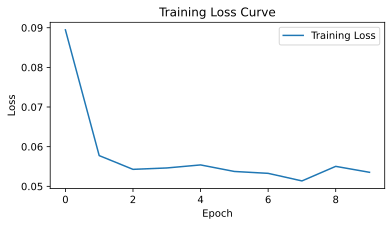

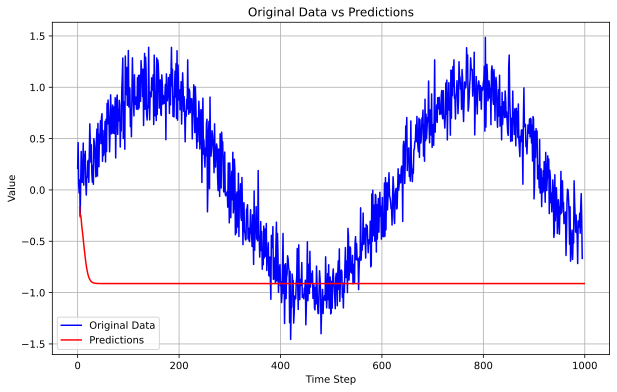

In [ ]:
# Example usage:
max_epochs = 10  # Specify the maximum number of epochs
rnn_trainer = RNNTrainer(input_size=1, hidden_size=32, output_size=1, lr=0.01, max_epochs=max_epochs)
rnn_trainer.train()

# Perform one-step prediction
predictions = rnn_trainer.predict()

# Plot original data and predictions
plt.figure(figsize=(10, 6))
plt.plot(rnn_trainer.data.x[rnn_trainer.data.tau:], label='Original Data', color='blue')
plt.plot(range(rnn_trainer.data.tau, rnn_trainer.data.T), predictions, label='Predictions', color='red')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Original Data vs Predictions')
plt.legend()
plt.grid(True)
plt.show()


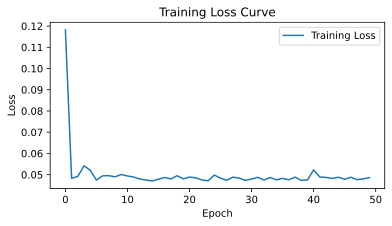

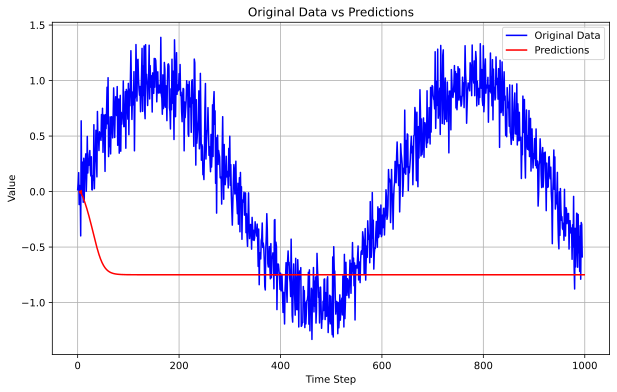

In [ ]:
# Increase model complexity
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):  # Adding more layers
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0):
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Use only the last time step for prediction
        return out

# Example usage with adjusted hyperparameters
max_epochs = 50  # Increase the number of epochs
rnn_trainer = RNNTrainer(input_size=1, hidden_size=64, output_size=1, lr=0.001, max_epochs=max_epochs)  # Adjust learning rate and hidden size
rnn_trainer.train()

# Perform one-step prediction
predictions = rnn_trainer.predict()

# Plot original data and predictions
plt.figure(figsize=(10, 6))
plt.plot(rnn_trainer.data.x[rnn_trainer.data.tau:], label='Original Data', color='blue')
plt.plot(range(rnn_trainer.data.tau, rnn_trainer.data.T), predictions, label='Predictions', color='red')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Original Data vs Predictions')
plt.legend()
plt.grid(True)
plt.show()


Predictions are not good under a rnn model